<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista02ARIMA_ARCH%2BGARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
! pip install yfinance statsmodels arch

In [83]:
! pip install pmdarima

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


### Carregar os dados de Bitcoin (BTC-USD) entre 2018 e 2022

In [92]:
data = yf.download('BTC-USD', start='2018-01-01', end='2022-06-30')
btc = data['Close']
print(btc)

[*********************100%***********************]  1 of 1 completed

Ticker           BTC-USD
Date                    
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
2018-01-05  17429.500000
...                  ...
2022-06-25  21502.337891
2022-06-26  21027.294922
2022-06-27  20735.478516
2022-06-28  20280.634766
2022-06-29  20104.023438

[1641 rows x 1 columns]


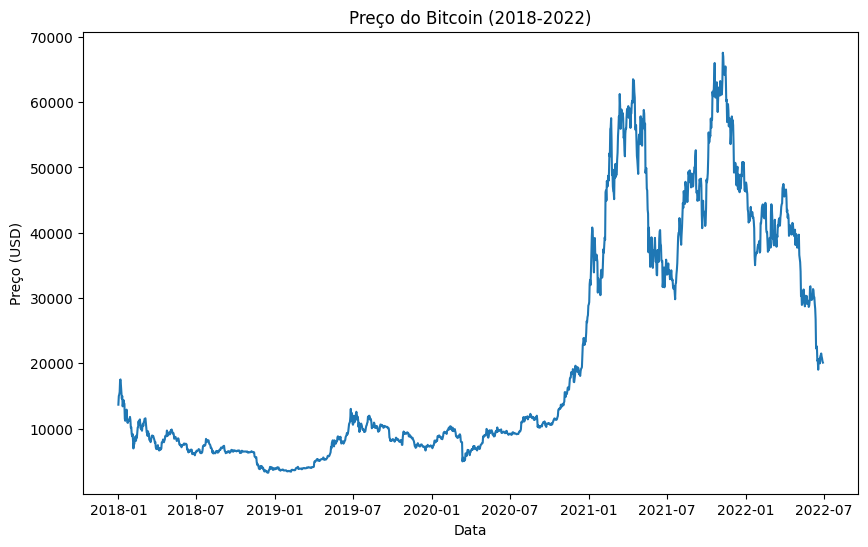

In [93]:
# 2. Plotar a série temporal
plt.figure(figsize=(10,6))
plt.plot(btc)
plt.title("Preço do Bitcoin (2018-2022)")
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.show()

### Teste de Dickey-Fuller Aumentado (ADF) para verificar estacionariedade

In [86]:
result = adfuller(btc)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

# Verificando se a série é estacionária ou não
if result[1] < 0.05:
    print("A série é estacionária (rejeitamos a hipótese nula).")
else:
    print("A série não é estacionária (não rejeitamos a hipótese nula).")

ADF Statistic: -1.3135506301583915
p-value: 0.6229503076370327
Critical Values: {'1%': -3.434403043188966, '5%': -2.863330182785859, '10%': -2.567723055843177}
A série não é estacionária (não rejeitamos a hipótese nula).


### 1 Diferenciação

In [87]:
btc_diff1 = btc.diff().dropna()

# Teste ADF na série diferenciada
result_diff1 = adfuller(btc_diff1)
print(f"ADF Statistic (após diferenciação): {result_diff1[0]}")
print(f"p-value (após diferenciação): {result_diff1[1]}")
print(f"Critical Values (após diferenciação): {result_diff1[4]}")

# Verificando se a série diferenciada é estacionária
if result_diff1[1] < 0.05:
    print("A série diferenciada é estacionária (rejeitamos a hipótese nula).")
else:
    print("A série diferenciada não é estacionária (não rejeitamos a hipótese nula).")

ADF Statistic (após diferenciação): -7.728858226260973
p-value (após diferenciação): 1.1395647066672066e-11
Critical Values (após diferenciação): {'1%': -3.434403043188966, '5%': -2.863330182785859, '10%': -2.567723055843177}
A série diferenciada é estacionária (rejeitamos a hipótese nula).


### Divisão dos dados em treino (70%) e teste (20%)

In [94]:
train_size = int(len(btc_diff2) * 0.7)
train, test = btc_diff2[:train_size], btc_diff2[train_size:]

### Buscar os melhores parâmetros (p, d, q) usando auto_arima no conjunto de treino

In [104]:
auto_model = auto_arima(train, seasonal=False, trace=True, suppress_warnings=True)
print(f"Melhores parâmetros ARIMA: {auto_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=670.021, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=676.169, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=668.048, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=668.123, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=667.683, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=669.143, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=669.383, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=668.599, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=670.605, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=667.687, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 1.574 seconds


### Arima (2,0,0)

In [118]:
arima_model = ARIMA(train, order=(2, 0, 0))
fitted_arima = arima_model.fit()
print(fitted_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                   36
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -329.873
Date:                Fri, 18 Apr 2025   AIC                            667.745
Time:                        17:56:24   BIC                            674.079
Sample:                    03-01-2018   HQIC                           669.956
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        329.0723    214.824      1.532      0.126     -91.975     750.120
ar.L1         -0.6938      0.130     -5.341      0.000      -0.948      -0.439
ar.L2         -0.3449      0.188     -1.839      0.0

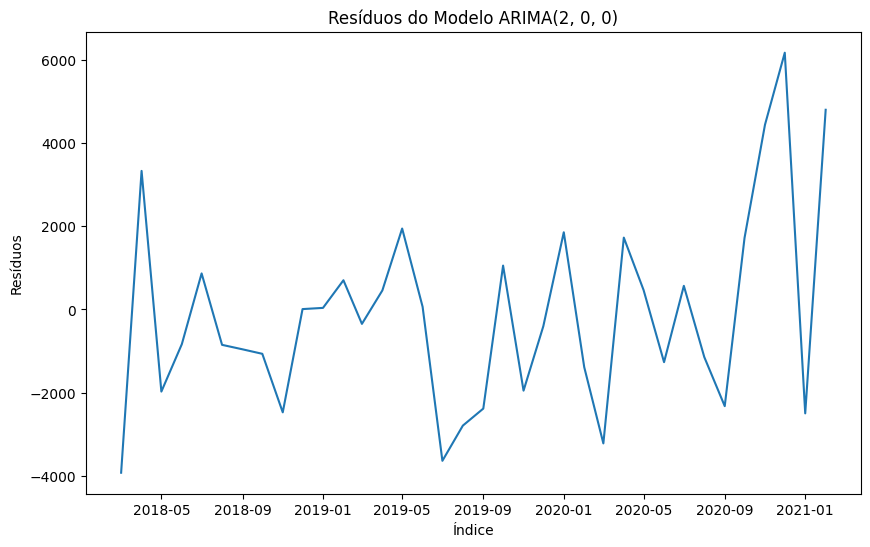

In [119]:
# Plotar os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Resíduos do Modelo ARIMA(2, 0, 0)')
plt.xlabel('Índice')
plt.ylabel('Resíduos')
plt.show()


<Figure size 1000x600 with 0 Axes>

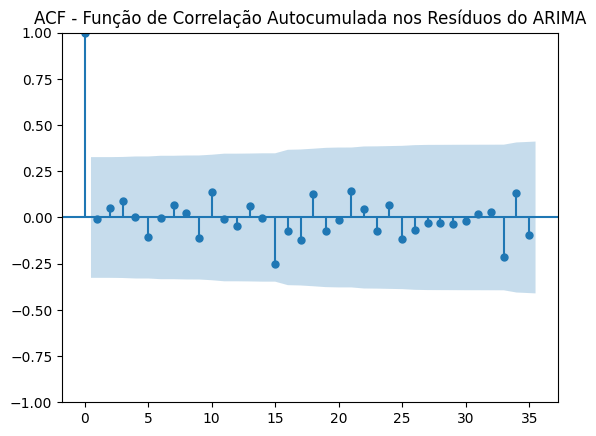

<Figure size 1000x600 with 0 Axes>

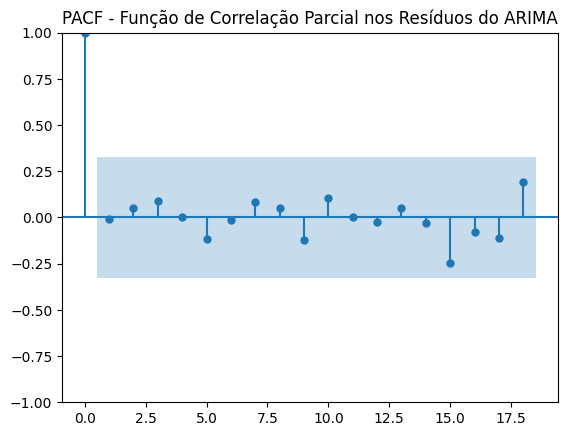

In [120]:
# 11. ACF e PACF nos resíduos do modelo ARIMA

# ACF - Função de Correlação Autocumulada nos resíduos
plt.figure(figsize=(10,6))
lags_acf = min(len(residuals) - 1, 40)  # Definir lags de acordo com o tamanho dos resíduos
plot_acf(residuals, lags=lags_acf)  # Aqui vamos usar os resíduos
plt.title("ACF - Função de Correlação Autocumulada nos Resíduos do ARIMA")
plt.show()

# PACF - Função de Correlação Parcial nos resíduos
plt.figure(figsize=(10,6))
lags_pacf = min(len(residuals) // 2, 40)  # Limitar a quantidade de lags a 50% do tamanho dos resíduos
plot_pacf(residuals, lags=lags_pacf)  # Limitar o número de lags
plt.title("PACF - Função de Correlação Parcial nos Resíduos do ARIMA")
plt.show()


## ARCH(1)

In [128]:
arch_mod = arch_model(residuals, vol="ARCH", p=1)
arch_fitted = arch_mod.fit(disp="off")
print("\nResumo do modelo ARCH(1):")
print(arch_fitted.summary())

# 7. Previsão da volatilidade condicional (ARCH)
arch_forecast = arch_fitted.forecast(horizon=5)
print("\nVolatilidade prevista com ARCH:")
print(arch_forecast.variance[-1:])


Resumo do modelo ARCH(1):
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -326.796
Distribution:                  Normal   AIC:                           659.591
Method:            Maximum Likelihood   BIC:                           664.342
                                        No. Observations:                   36
Date:                Fri, Apr 18 2025   Df Residuals:                       35
Time:                        18:05:49   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          -327.2855    281


Resumo do modelo ARCH(1):
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -326.796
Distribution:                  Normal   AIC:                           659.591
Method:            Maximum Likelihood   BIC:                           664.342
                                        No. Observations:                   36
Date:                Fri, Apr 18 2025   Df Residuals:                       35
Time:                        18:07:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu          -327.2855    281

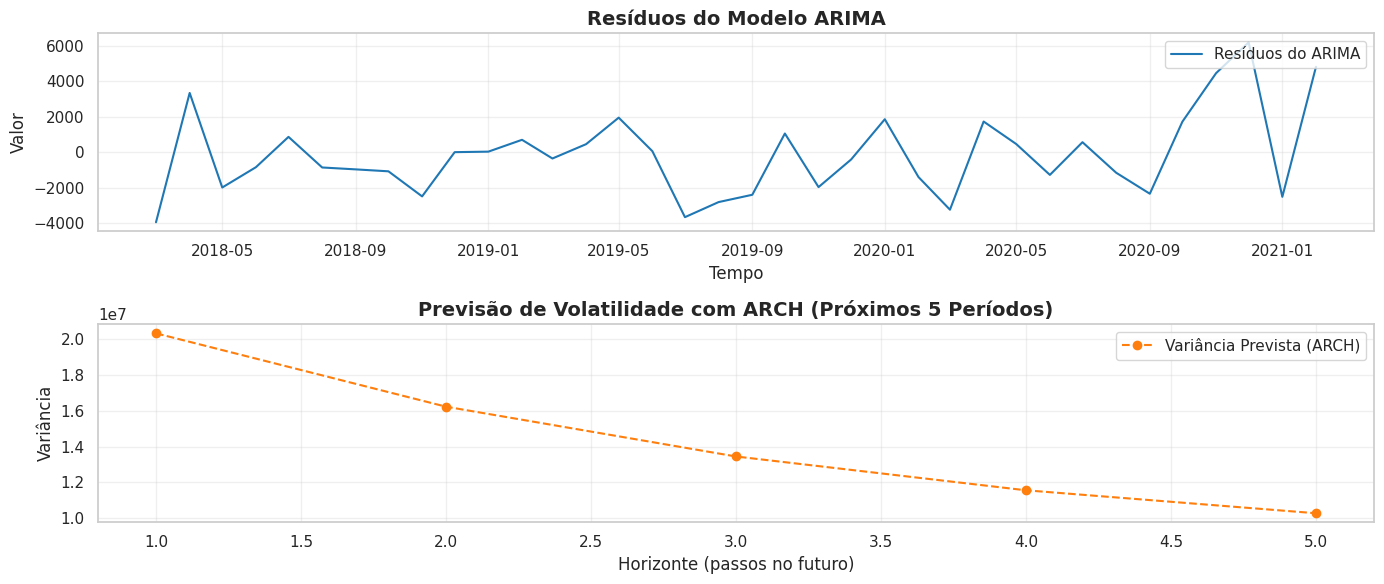

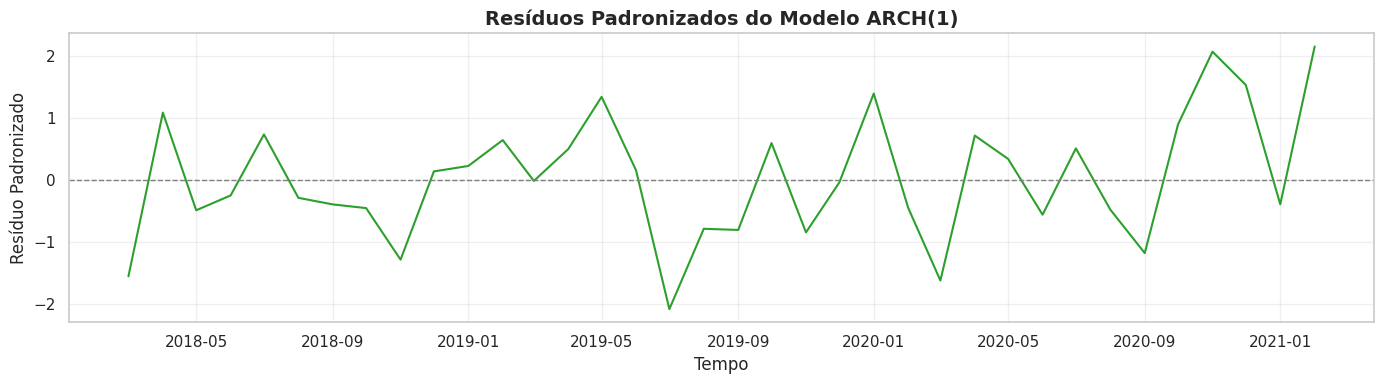

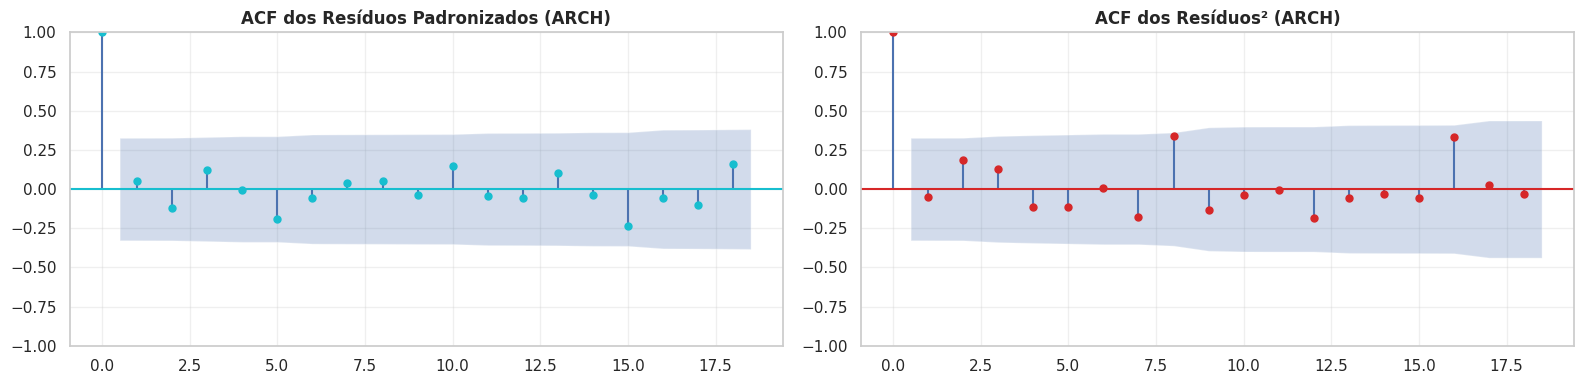

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

# Treinando o modelo ARCH(1)
arch_mod = arch_model(residuals, vol="ARCH", p=1)
arch_fitted = arch_mod.fit(disp="off")

print("\nResumo do modelo ARCH(1):")
print(arch_fitted.summary())

# Previsão da volatilidade para 5 períodos à frente
arch_forecast = arch_fitted.forecast(horizon=5)
predicted_variance_arch = arch_forecast.variance.iloc[-1]

print("\nVolatilidade prevista com ARCH:")
print(predicted_variance_arch)

# Resíduos padronizados do ARCH
residuos_arch = arch_fitted.std_resid.dropna()
residuos_arch2 = residuos_arch ** 2

# Estilo visual
sns.set(style='whitegrid')

# --- Forecast da volatilidade com ARCH + Resíduos do ARIMA ---
plt.figure(figsize=(14, 6))

# Resíduos do ARIMA (mesmo residual usado para entrada no modelo ARCH)
plt.subplot(2, 1, 1)
plt.plot(residuals, label='Resíduos do ARIMA', color='#1f77b4')
plt.title('Resíduos do Modelo ARIMA', fontsize=14, weight='bold')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Volatilidade prevista com ARCH
plt.subplot(2, 1, 2)
plt.plot(range(1, 6), predicted_variance_arch.values, marker='o', linestyle='--',
         color='#ff7f0e', label='Variância Prevista (ARCH)')
plt.title('Previsão de Volatilidade com ARCH (Próximos 5 Períodos)', fontsize=14, weight='bold')
plt.xlabel('Horizonte (passos no futuro)')
plt.ylabel('Variância')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Resíduos padronizados do ARCH ---
plt.figure(figsize=(14, 4))
plt.plot(residuos_arch, color='#2ca02c')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title("Resíduos Padronizados do Modelo ARCH(1)", fontsize=14, weight='bold')
plt.xlabel("Tempo")
plt.ylabel("Resíduo Padronizado")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- ACF dos resíduos e resíduos² do ARCH lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF dos resíduos padronizados
plot_acf(residuos_arch, lags=min(40, len(residuos_arch)//2), ax=axes[0], color='#17becf')
axes[0].set_title("ACF dos Resíduos Padronizados (ARCH)", fontsize=12, weight='bold')
axes[0].grid(alpha=0.3)

# ACF dos resíduos²
plot_acf(residuos_arch2, lags=min(40, len(residuos_arch2)//2), ax=axes[1], color='#d62728')
axes[1].set_title("ACF dos Resíduos² (ARCH)", fontsize=12, weight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## GARCH (1,1)

In [121]:
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp="off")  # silenciar output
print("\nResumo do modelo GARCH(1,1):")
print(garch_fitted.summary())


Resumo do modelo GARCH(1,1):
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -325.792
Distribution:                  Normal   AIC:                           659.583
Method:            Maximum Likelihood   BIC:                           665.918
                                        No. Observations:                   36
Date:                Fri, Apr 18 2025   Df Residuals:                       35
Time:                        17:57:26   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu          -440.3268    269.88

In [122]:
garch_forecast = garch_fitted.forecast(horizon=5)
print("\nVolatilidade prevista com GARCH:")
print(garch_forecast.variance[-1:])


Volatilidade prevista com GARCH:
                     h.1           h.2           h.3           h.4  \
Date                                                                 
2021-02-01  1.976650e+07  1.719391e+07  1.516711e+07  1.357030e+07   

                     h.5  
Date                      
2021-02-01  1.231225e+07  


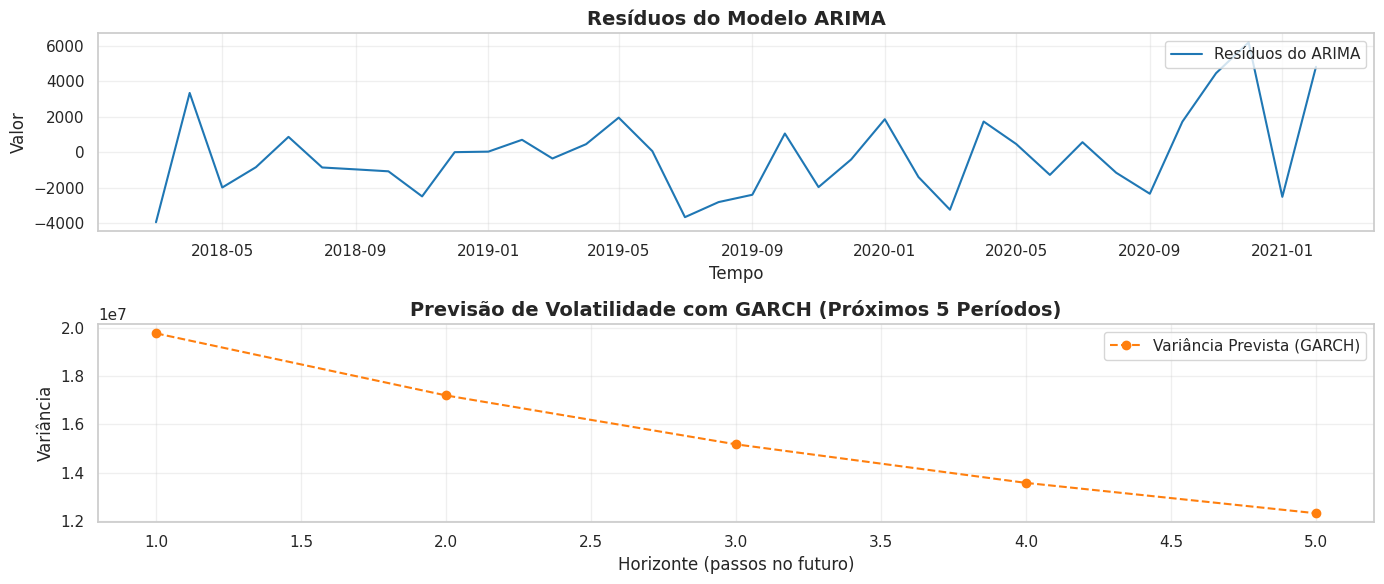

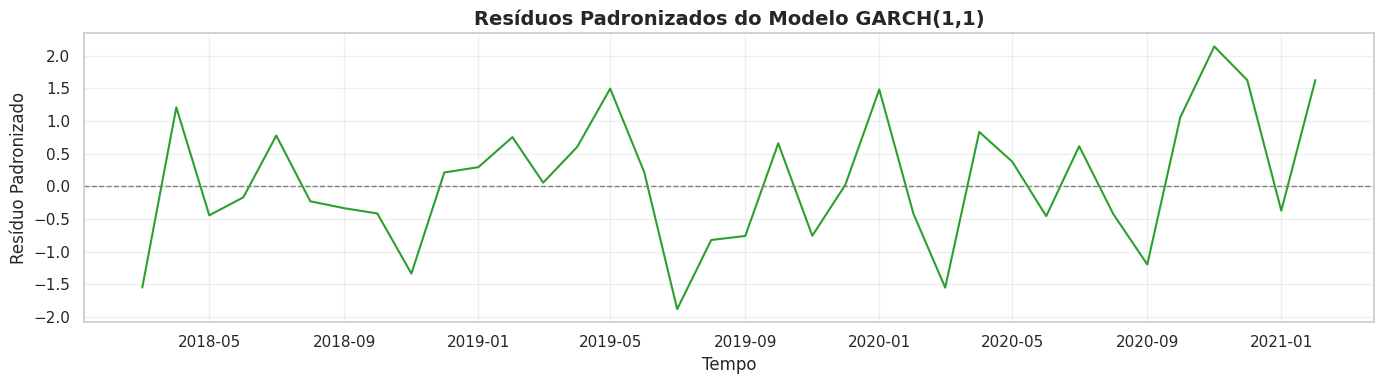

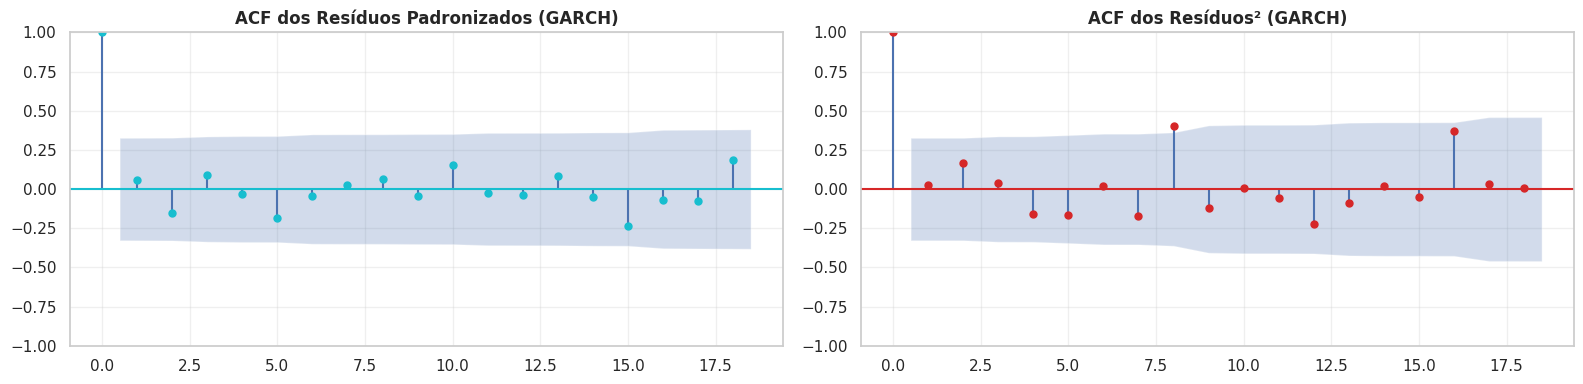

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Estilo visual agradável
sns.set(style='whitegrid')

# --- Forecast da volatilidade com GARCH + Resíduos do ARIMA ---
plt.figure(figsize=(14, 6))

# Resíduos do ARIMA
plt.subplot(2, 1, 1)
plt.plot(residuals, label='Resíduos do ARIMA', color='#1f77b4')
plt.title('Resíduos do Modelo ARIMA', fontsize=14, weight='bold')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Volatilidade prevista com GARCH
plt.subplot(2, 1, 2)
plt.plot(range(1, 6), predicted_variance.values, marker='o', linestyle='--',
         color='#ff7f0e', label='Variância Prevista (GARCH)')
plt.title('Previsão de Volatilidade com GARCH (Próximos 5 Períodos)', fontsize=14, weight='bold')
plt.xlabel('Horizonte (passos no futuro)')
plt.ylabel('Variância')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Resíduos padronizados do GARCH ---
plt.figure(figsize=(14, 4))
plt.plot(residuos_garch, color='#2ca02c')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title("Resíduos Padronizados do Modelo GARCH(1,1)", fontsize=14, weight='bold')
plt.xlabel("Tempo")
plt.ylabel("Resíduo Padronizado")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- ACF dos resíduos e resíduos² lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF dos resíduos padronizados
plot_acf(residuos_garch, lags=min(40, len(residuos_garch)//2), ax=axes[0], color='#17becf')
axes[0].set_title("ACF dos Resíduos Padronizados (GARCH)", fontsize=12, weight='bold')
axes[0].grid(alpha=0.3)

# ACF dos resíduos²
residuos_garch2 = residuos_garch ** 2
plot_acf(residuos_garch2, lags=min(40, len(residuos_garch2)//2), ax=axes[1], color='#d62728')
axes[1].set_title("ACF dos Resíduos² (GARCH)", fontsize=12, weight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()





### Previsões do ARIMA

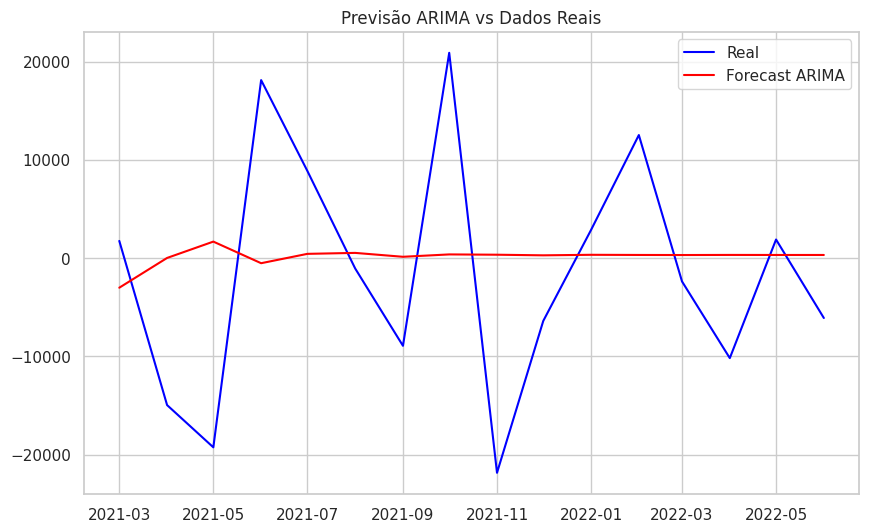

Erro Quadrático Médio (MSE): 153938974.77410752
Erro Absoluto Médio (MAE): 10230.594962177109
Raiz do Erro Quadrático Médio (RMSE): 12407.214625938714


In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 15. Previsão do modelo ARIMA para os dados de teste
forecast_arima = fitted_model.forecast(steps=len(test))  # Previsões para o conjunto de teste

# 16. Comparando as previsões ARIMA com os dados reais (test)
plt.figure(figsize=(10,6))
plt.plot(test, label="Real", color='blue')  # Dados reais
plt.plot(forecast_arima, label="Forecast ARIMA", color='red')  # Previsões ARIMA
plt.title("Previsão ARIMA vs Dados Reais")
plt.legend()
plt.show()

# 17. Cálculo das métricas de avaliação
mse = mean_squared_error(test, forecast_arima)  # Erro Quadrático Médio
mae = mean_absolute_error(test, forecast_arima)  # Erro Absoluto Médio

print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"Erro Absoluto Médio (MAE): {mae}")

# Cálculo do RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse}")


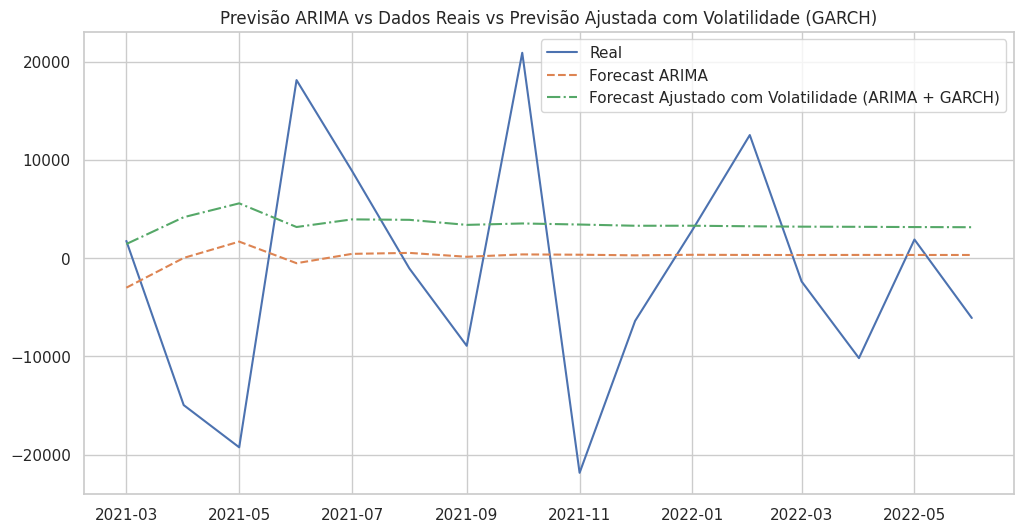

MSE Ajustado: 176444700.47363177
MAE Ajustado: 10805.24915427525
RMSE Ajustado: 13283.248867413115


In [131]:
# 1. Previsão do ARIMA (já feito anteriormente)
forecast_arima = fitted_model.forecast(steps=len(test))

# 2. Previsão da volatilidade com GARCH
garch_forecast = garch_fitted.forecast(horizon=len(test))
predicted_volatility = garch_forecast.variance.values[-1, :]

# 3. Ajustando a previsão do ARIMA com a volatilidade do GARCH
# A ideia é multiplicar as previsões do ARIMA pela raiz quadrada da volatilidade (desvio padrão) prevista
adjusted_forecast = forecast_arima + np.sqrt(predicted_volatility)

# 4. Comparando a previsão ajustada com os dados reais
plt.figure(figsize=(12, 6))
plt.plot(test, label="Real")
plt.plot(forecast_arima, label="Forecast ARIMA", linestyle='--')
plt.plot(adjusted_forecast, label="Forecast Ajustado com Volatilidade (ARIMA + GARCH)", linestyle='-.')
plt.title("Previsão ARIMA vs Dados Reais vs Previsão Ajustada com Volatilidade (GARCH)")
plt.legend()
plt.show()

# 5. Avaliação do modelo ajustado (MSE, MAE, RMSE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse_adjusted = mean_squared_error(test, adjusted_forecast)
mae_adjusted = mean_absolute_error(test, adjusted_forecast)
rmse_adjusted = sqrt(mse_adjusted)

print(f"MSE Ajustado: {mse_adjusted}")
print(f"MAE Ajustado: {mae_adjusted}")
print(f"RMSE Ajustado: {rmse_adjusted}")


In [135]:
print(train.columns)  # Para verificar as colunas do dataset de treino
print(test.columns)   # Para verificar as colunas do dataset de teste

print(train.head())   # Para visualizar as primeiras linhas do dataset de treino
print(test.head())    # Para visualizar as primeiras linhas do dataset de teste



Index(['BTC-USD'], dtype='object', name='Ticker')
Index(['BTC-USD'], dtype='object', name='Ticker')
Ticker          BTC-USD
Date                   
2018-03-01 -3601.171387
2018-04-01  5691.390625
2018-05-01 -4013.399902
2018-06-01   656.209961
2018-07-01  2466.609863
Ticker           BTC-USD
Date                    
2021-03-01   1757.652344
2021-04-01 -14949.718750
2021-05-01 -19248.664062
2021-06-01  18125.300781
2021-07-01   8877.378906


In [141]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00


In [153]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, HBox

# Função de plotagem com checkboxes
def plot_forecasts(show_arima, show_garch, show_train, show_test):
    # Ajuste do tamanho da figura
    plt.figure(figsize=(40, 20))  # Aumentando largura para 30 e altura para 15

    # Plotando a série temporal de treino (opcional)
    if show_train:
        train.plot(legend=True, label='Train', color='blue', linewidth=2)

    # Plotando a previsão do ARIMA (opcional)
    if show_arima:
        mean_forecast.plot(legend=True, label='ARIMA Prediction', color='green', linewidth=2, linestyle='--')

    # Plotando a previsão simulada do GARCH (opcional)
    if show_garch:
        simulated_return.plot(legend=True, label='GARCH Prediction', color='red', linewidth=2, linestyle=':')

    # Plotando a série temporal de teste (opcional)
    if show_test:
        test_series = test['BTC-USD']  # Supondo que a série de teste tem a mesma estrutura
        test_series.plot(legend=True, label='Test', color='orange', linewidth=2, linestyle='-.')

    # Adicionando título
    plt.title("ARIMA & GARCH Forecast vs Real Data", fontsize=16, weight='bold')

    # Adicionando rótulos para os eixos
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)

    # Melhorando a legenda
    plt.legend(loc='upper left', fontsize=12, title="Model", title_fontsize='13', frameon=True)

    # Adicionando gridlines para facilitar a leitura
    plt.grid(True)

    # Ajustando os parâmetros do gráfico para o tamanho aumentado
    plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)

    # Exibindo o gráfico
    plt.show()

# Criando os checkboxes interativos
checkboxes = HBox([
    widgets.Checkbox(value=True, description='ARIMA'),
    widgets.Checkbox(value=True, description='GARCH'),
    widgets.Checkbox(value=True, description='Train Data'),
    widgets.Checkbox(value=True, description='Test Data')
])

# Função interativa com os checkboxes na lateral
interact(
    plot_forecasts,
    show_arima=checkboxes.children[0],
    show_garch=checkboxes.children[1],
    show_train=checkboxes.children[2],
    show_test=checkboxes.children[3]
)






interactive(children=(Checkbox(value=True, description='ARIMA'), Checkbox(value=True, description='GARCH'), Ch…

<function __main__.plot_forecasts(show_arima, show_garch, show_train, show_test)>